# Nested Logit Model: Simulate different scenarios with different prices for public transportation

In [1]:
import pandas as pd
import numpy as np
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.optimization as opt
import biogeme.results as res
from biogeme.expressions import Beta, DefineVariable
import seaborn as sns
import matplotlib.pyplot as plt

**Import Optima data**

In [2]:
pandas = pd.read_csv("../../Data/8-DiscreteChoiceModels/optima.dat",sep='\t')
database = db.Database ("data/optima", pandas)

**Use collumn names as variables**

In [3]:
globals().update(database.variables)

**Exclude some unwanted entries**

In [4]:
exclude = (Choice == -1.)
database.remove(exclude)

**Rescale some data**

In [5]:
TimePT_scaled = TimePT / 200
TimeCar_scaled = TimeCar / 200
MarginalCostPT_scaled = MarginalCostPT / 10 
CostCarCHF_scaled = CostCarCHF / 10
distance_km_scaled = distance_km / 5

**Define some dummy variables**

In [6]:
male = (Gender == 1)
female = (Gender == 2)
unreportedGender = (Gender == -1)

fulltime = (OccupStat == 1)
notfulltime = (OccupStat != 1)

**Compute normalizing weights for each alternative**

In [7]:
sumWeight = database.data['Weight'].sum()
normalized_Weight = Weight * len(database.data['Weight']) / sumWeight

**Define a scenario calculator to simulate different prices of public transportation**

In [8]:
def scenario(scale):
    # Define variables that depend on cost
    MarginalCostScenario = MarginalCostPT * scale
    MarginalCostPT_scaled = MarginalCostScenario / 10
    
    # Define other variables
    ASC_CAR = Beta('ASC_CAR',0,None,None,0)
    ASC_PT = Beta('ASC_PT',0,None,None,1)
    ASC_SM = Beta('ASC_SM',0,None,None,0)
    BETA_TIME_FULLTIME = Beta('BETA_TIME_FULLTIME',0,None,None,0)
    BETA_TIME_OTHER = Beta('BETA_TIME_OTHER',0,None,None,0)
    BETA_DIST_MALE = Beta('BETA_DIST_MALE',0,None,None,0)
    BETA_DIST_FEMALE = Beta('BETA_DIST_FEMALE',0,None,None,0)
    BETA_DIST_UNREPORTED = Beta('BETA_DIST_UNREPORTED',0,None,None,0)
    BETA_COST = Beta('BETA_COST',0,None,None,0)

    # Utility functions
    V_PT = ASC_PT + BETA_TIME_FULLTIME * TimePT_scaled * fulltime + \
           BETA_TIME_OTHER * TimePT_scaled * notfulltime + \
           BETA_COST * MarginalCostPT_scaled
    V_CAR = ASC_CAR + \
            BETA_TIME_FULLTIME * TimeCar_scaled * fulltime + \
            BETA_TIME_OTHER * TimeCar_scaled * notfulltime + \
            BETA_COST * CostCarCHF_scaled
    V_SM = ASC_SM + \
           BETA_DIST_MALE * distance_km_scaled * male + \
           BETA_DIST_FEMALE * distance_km_scaled * female + \
           BETA_DIST_UNREPORTED * distance_km_scaled * unreportedGender
    
    # Aggregate utility functions
    V = {0: V_PT,
         1: V_CAR,
         2: V_SM}
    
    # Availability of alternatives
    av = {0: 1,
          1: 1,
          2: 1}
    
    # Nests definitions
    MU_NO_CAR = Beta('MU_NO_CAR',1.0,1.0,None,0)
    CAR_NEST = 1.0 , [ 1]
    NO_CAR_NEST = MU_NO_CAR , [ 0, 2]
    nests = CAR_NEST, NO_CAR_NEST
    
    # Model
    prob_pt = models.nested(V,av,nests,0)
    
    # Define simulation variables
    simulate = {'weight': normalized_Weight,
                'Revenue public transportation':
                   prob_pt * MarginalCostScenario}

    # Create Biogeme object
    biogeme  = bio.BIOGEME(database,simulate)
    betas = biogeme.freeBetaNames

    # Read the estimation results from the previously estimated model
    results = res.bioResults(pickleFile='optima_nested_logit.pickle')

    # Extract the values that are necessary
    betaValues = results.getBetaValues(betas)
    
    # Simulate
    simulatedValues = biogeme.simulate(betaValues)

    # We calculate the sum for all individuals of the generated revenues.
    revenues_pt = (simulatedValues['Revenue public transportation'] * simulatedValues['weight']).sum()
    return revenues_pt

**Create scales for different pricings on the public transportation and run the different scenarios**

In [9]:
scales = np.arange(0.0,5.0,0.1)
revenues = [scenario(s) for s in scales]

**Plot the results**

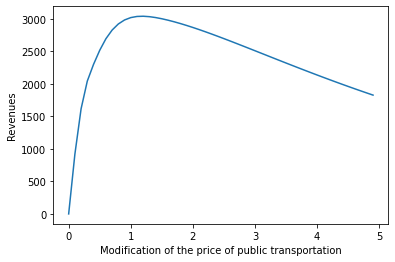

In [10]:
plt.plot(scales,revenues)
plt.xlabel("Modification of the price of public transportation")
plt.ylabel("Revenues")
plt.show()